# Important Neuron Analysis

This notebook provides deeper analysis of "important" neurons (SAE features) identified through IG² scores.

## Analysis Scope:
- **Cross-Layer Trajectory**: Track how neuron importance metrics evolve from Layer 8 → Layer 16 → Layer 24
- **Cross-Demographic Comparison**: Compare which neurons are important across different demographics within each layer

## Filtering Method:
- **Percentile-based**: Features above 95th and 99th percentile of IG² scores

## Key Metrics:
- **Concentration Index**: `sum(top-k scores) / sum(all scores)` - measures bias concentration
- **Jaccard Similarity**: `|A∩B| / |A∪B|` - measures feature overlap between demographics
- **Layer Change Ratio**: `(score_L2 - score_L1) / score_L1` - tracks importance changes

## Prerequisites:
- Run IG² computation for all 9 demographics and 3 layers
- Results stored in `results/{stage}/{demographic}/ig2/`

In [1]:
import os
import sys
import warnings
from pathlib import Path
from collections import defaultdict
from itertools import combinations

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Add project root to path
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.visualization import ensure_korean_font
from src.utils import load_json

warnings.filterwarnings('ignore')

print(f"Project root: {PROJECT_ROOT}")

/home/youngjins/miniconda3/envs/belief_llm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Project root: /home/youngjins/project/global_ai_frontier/korean-bias-sae


In [2]:
# Setup Korean font
font_name = ensure_korean_font()

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Font configured: ['DejaVu Sans']


In [3]:
# Configuration
RESULTS_DIR = PROJECT_ROOT / "results"
DATA_DIR = PROJECT_ROOT / "data"
ASSETS_DIR = PROJECT_ROOT / "notebooks" / "visualizations" / "assets"
ASSETS_DIR.mkdir(exist_ok=True, parents=True)

# Stage
STAGE = "full"

# Percentile thresholds for filtering
PERCENTILES = [95, 99]

# Layer quantiles
LAYER_QUANTILES = ["q1", "q2", "q3"]
LAYER_LABELS = {
    "q1": "Layer 8",
    "q2": "Layer 16",
    "q3": "Layer 24"
}

# Load demographics
demo_dict = load_json(DATA_DIR / "demographic_dict_ko.json")
DEMOGRAPHICS = list(demo_dict.keys())
DEMOGRAPHIC_EN = {d: demo_dict[d]['dimension_en'] for d in DEMOGRAPHICS}

print(f"Stage: {STAGE}")
print(f"Percentile Thresholds: {PERCENTILES}")
print(f"Layer Quantiles: {LAYER_QUANTILES}")
print(f"\nDemographics ({len(DEMOGRAPHICS)}):")
for d in DEMOGRAPHICS:
    print(f"  - {d} ({DEMOGRAPHIC_EN[d]})")

Stage: full
Percentile Thresholds: [95, 99]
Layer Quantiles: ['q1', 'q2', 'q3']

Demographics (9):
  - 성별 (gender)
  - 인종 (ethnicity)
  - 종교 (religion)
  - 성적지향 (sexuality)
  - 나이 (age)
  - 외모 (physical appearance)
  - 경제수준 (socioeconomic status)
  - 정치성향 (politics)
  - 직업 (occupation)


---
## Data Loading

In [4]:
def load_ig2_results(results_dir, stage, demographic, layer_quantile):
    """
    Load IG² attribution results.
    
    Returns:
        dict with 'scores', 'bias_features', 'threshold', 'metadata'
        or None if not found
    """
    ig2_path = results_dir / stage / demographic / 'ig2' / f'{layer_quantile}_ig2_results.pt'
    
    if not ig2_path.exists():
        # Fallback to legacy path
        legacy_path = results_dir / stage / demographic / 'ig2' / 'ig2_results.pt'
        if legacy_path.exists():
            ig2_path = legacy_path
        else:
            return None
    
    data = torch.load(ig2_path, map_location='cpu')
    
    # Extract scores
    if isinstance(data, dict):
        scores = data.get('feature_scores', data.get('ig2_scores', None))
        if scores is not None and isinstance(scores, torch.Tensor):
            scores = scores.cpu().numpy()
        return {
            'scores': scores,
            'bias_features': data.get('bias_features', None),
            'threshold': data.get('threshold', None),
            'metadata': data.get('metadata', {})
        }
    elif isinstance(data, torch.Tensor):
        return {
            'scores': data.cpu().numpy(),
            'bias_features': None,
            'threshold': None,
            'metadata': {}
        }
    return None


print("Data loading function defined.")

Data loading function defined.


In [5]:
# Load all IG² results
ig2_data = {}  # {demographic: {layer: {'scores': array, 'metadata': dict}}}

print("Loading IG² results...\n")

for demo in DEMOGRAPHICS:
    ig2_data[demo] = {}
    for lq in LAYER_QUANTILES:
        data = load_ig2_results(RESULTS_DIR, STAGE, demo, lq)
        if data and data['scores'] is not None:
            ig2_data[demo][lq] = data

# Summary
print("Loaded IG² Results Summary:")
print("=" * 70)
print(f"{'Demographic':<20} | {'Q1':<10} | {'Q2':<10} | {'Q3':<10}")
print("-" * 70)

for demo in DEMOGRAPHICS:
    demo_en = DEMOGRAPHIC_EN[demo]
    row = f"{demo_en:<20} |"
    for lq in LAYER_QUANTILES:
        if lq in ig2_data[demo]:
            n_features = len(ig2_data[demo][lq]['scores'])
            row += f" {n_features:,}    |"
        else:
            row += f" --        |"
    print(row)

print("-" * 70)

Loading IG² results...

Loaded IG² Results Summary:
Demographic          | Q1         | Q2         | Q3        
----------------------------------------------------------------------
gender               | 100,000    | 100,000    | 100,000    |
ethnicity            | 100,000    | 100,000    | 100,000    |
religion             | 100,000    | 100,000    | 100,000    |
sexuality            | 100,000    | 100,000    | 100,000    |
age                  | 100,000    | 100,000    | 100,000    |
physical appearance  | 100,000    | 100,000    | 100,000    |
socioeconomic status | 100,000    | 100,000    | 100,000    |
politics             | 100,000    | 100,000    | 100,000    |
occupation           | 100,000    | 100,000    | 100,000    |
----------------------------------------------------------------------


---
## Section 1: Percentile-Based Feature Filtering

### How It's Computed:
For each demographic-layer combination, we compute the percentile threshold from non-zero IG² scores. Features with scores >= threshold are considered "important". We use 95th and 99th percentiles to identify moderately and highly important features respectively.

### Analysis:
The 99th percentile captures the most critical bias-encoding features (top 1%), while 95th percentile captures a broader set (top 5%). Comparing feature counts across layers reveals where bias information is more concentrated vs. distributed.

In [6]:
def filter_features_by_percentile(scores, percentile):
    """
    Filter features by percentile threshold on non-zero scores.
    
    Args:
        scores: numpy array of IG² scores
        percentile: percentile threshold (e.g., 95, 99)
    
    Returns:
        important_indices: indices of features above threshold
        threshold: computed threshold value
    """
    nonzero_scores = scores[scores > 0]
    if len(nonzero_scores) == 0:
        return np.array([]), 0.0
    
    threshold = np.percentile(nonzero_scores, percentile)
    important_indices = np.where(scores >= threshold)[0]
    return important_indices, threshold


def compute_concentration_index(scores, top_k=10):
    """
    Compute concentration index: sum(top-k scores) / sum(all scores).
    Higher values mean bias is concentrated in fewer features.
    """
    total_score = scores.sum()
    if total_score == 0:
        return 0.0
    
    top_k_scores = np.sort(scores)[-top_k:]
    return top_k_scores.sum() / total_score


print("Filtering functions defined.")

Filtering functions defined.


In [7]:
# Compute statistics for all demographic-layer combinations
stats_data = []

for demo in DEMOGRAPHICS:
    demo_en = DEMOGRAPHIC_EN[demo]
    for lq in LAYER_QUANTILES:
        if lq not in ig2_data[demo]:
            continue
        
        scores = ig2_data[demo][lq]['scores']
        
        row = {
            'Demographic': demo,
            'Demographic_EN': demo_en,
            'Layer': lq,
            'Layer_Label': LAYER_LABELS[lq],
            'Max_Score': scores.max(),
            'Max_Neuron_Idx': int(np.argmax(scores)),
            'Total_Nonzero': int((scores > 0).sum()),
            'Total_Score_Sum': scores.sum(),
            'Concentration_Top10': compute_concentration_index(scores, 10),
            'Concentration_Top50': compute_concentration_index(scores, 50),
            'Concentration_Top100': compute_concentration_index(scores, 100),
        }
        
        # Compute percentile-based filtering
        for p in PERCENTILES:
            indices, threshold = filter_features_by_percentile(scores, p)
            row[f'P{p}_Count'] = len(indices)
            row[f'P{p}_Threshold'] = threshold
            row[f'P{p}_Indices'] = indices  # Store for later use
        
        stats_data.append(row)

df_stats = pd.DataFrame(stats_data)

print(f"Computed statistics for {len(df_stats)} demographic-layer combinations")
print("\nSample data:")
display_cols = ['Demographic_EN', 'Layer', 'Max_Score', 'Total_Nonzero', 
                'P95_Count', 'P99_Count', 'Concentration_Top10']
print(df_stats[display_cols].head(12).to_string(index=False))

Computed statistics for 27 demographic-layer combinations

Sample data:
Demographic_EN Layer  Max_Score  Total_Nonzero  P95_Count  P99_Count  Concentration_Top10
        gender    q1   0.387639            192         10          2             0.582999
        gender    q2   0.437685            635         32          7             0.501064
        gender    q3   0.448949           2294        115         23             0.465308
     ethnicity    q1   0.687645            559         28          6             0.635601
     ethnicity    q2   0.497052            866         44          9             0.485036
     ethnicity    q3   0.493965           1341         68         14             0.416249
      religion    q1   0.622936            203         11          3             0.760738
      religion    q2   0.543364            503         26          6             0.603368
      religion    q3   0.526453            786         40          8             0.482225
     sexuality    q1   0.573

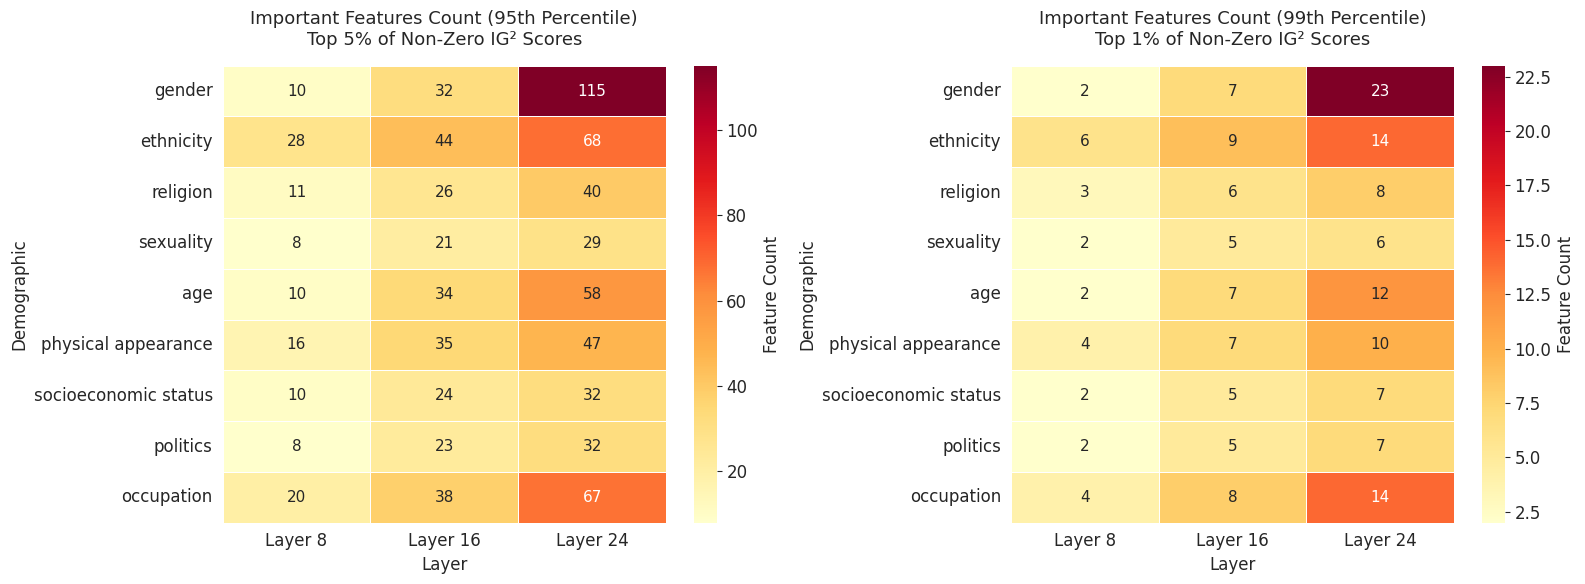


Feature Count Statistics by Percentile:

95th Percentile (Top 5%):
  Layer 8: Mean=13.4, Min=8, Max=28
  Layer 16: Mean=30.8, Min=21, Max=44
  Layer 24: Mean=54.2, Min=29, Max=115

99th Percentile (Top 1%):
  Layer 8: Mean=3.0, Min=2, Max=6
  Layer 16: Mean=6.6, Min=5, Max=9
  Layer 24: Mean=11.2, Min=6, Max=23


In [8]:
# Visualize: Feature count by percentile threshold
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]

for idx, p in enumerate(PERCENTILES):
    ax = axes[idx]
    
    # Pivot
    pivot = df_stats.pivot(index='Demographic_EN', columns='Layer', values=f'P{p}_Count')
    pivot = pivot.reindex(demo_en_ordered)
    pivot = pivot[['q1', 'q2', 'q3']]
    pivot.columns = ['Layer 8', 'Layer 16', 'Layer 24']
    
    sns.heatmap(
        pivot,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': f'Feature Count'},
        linewidths=0.5,
        annot_kws={'fontsize': 11}
    )
    
    ax.set_title(f'Important Features Count ({p}th Percentile)\nTop {100-p}% of Non-Zero IG² Scores', 
                 fontsize=13, pad=15)
    ax.set_xlabel('Layer', fontsize=12)
    ax.set_ylabel('Demographic', fontsize=12)

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_percentile_counts_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\nFeature Count Statistics by Percentile:")
print("=" * 60)
for p in PERCENTILES:
    print(f"\n{p}th Percentile (Top {100-p}%):")
    for lq in LAYER_QUANTILES:
        lq_data = df_stats[df_stats['Layer'] == lq]
        print(f"  {LAYER_LABELS[lq]}: Mean={lq_data[f'P{p}_Count'].mean():.1f}, "
              f"Min={lq_data[f'P{p}_Count'].min()}, Max={lq_data[f'P{p}_Count'].max()}")

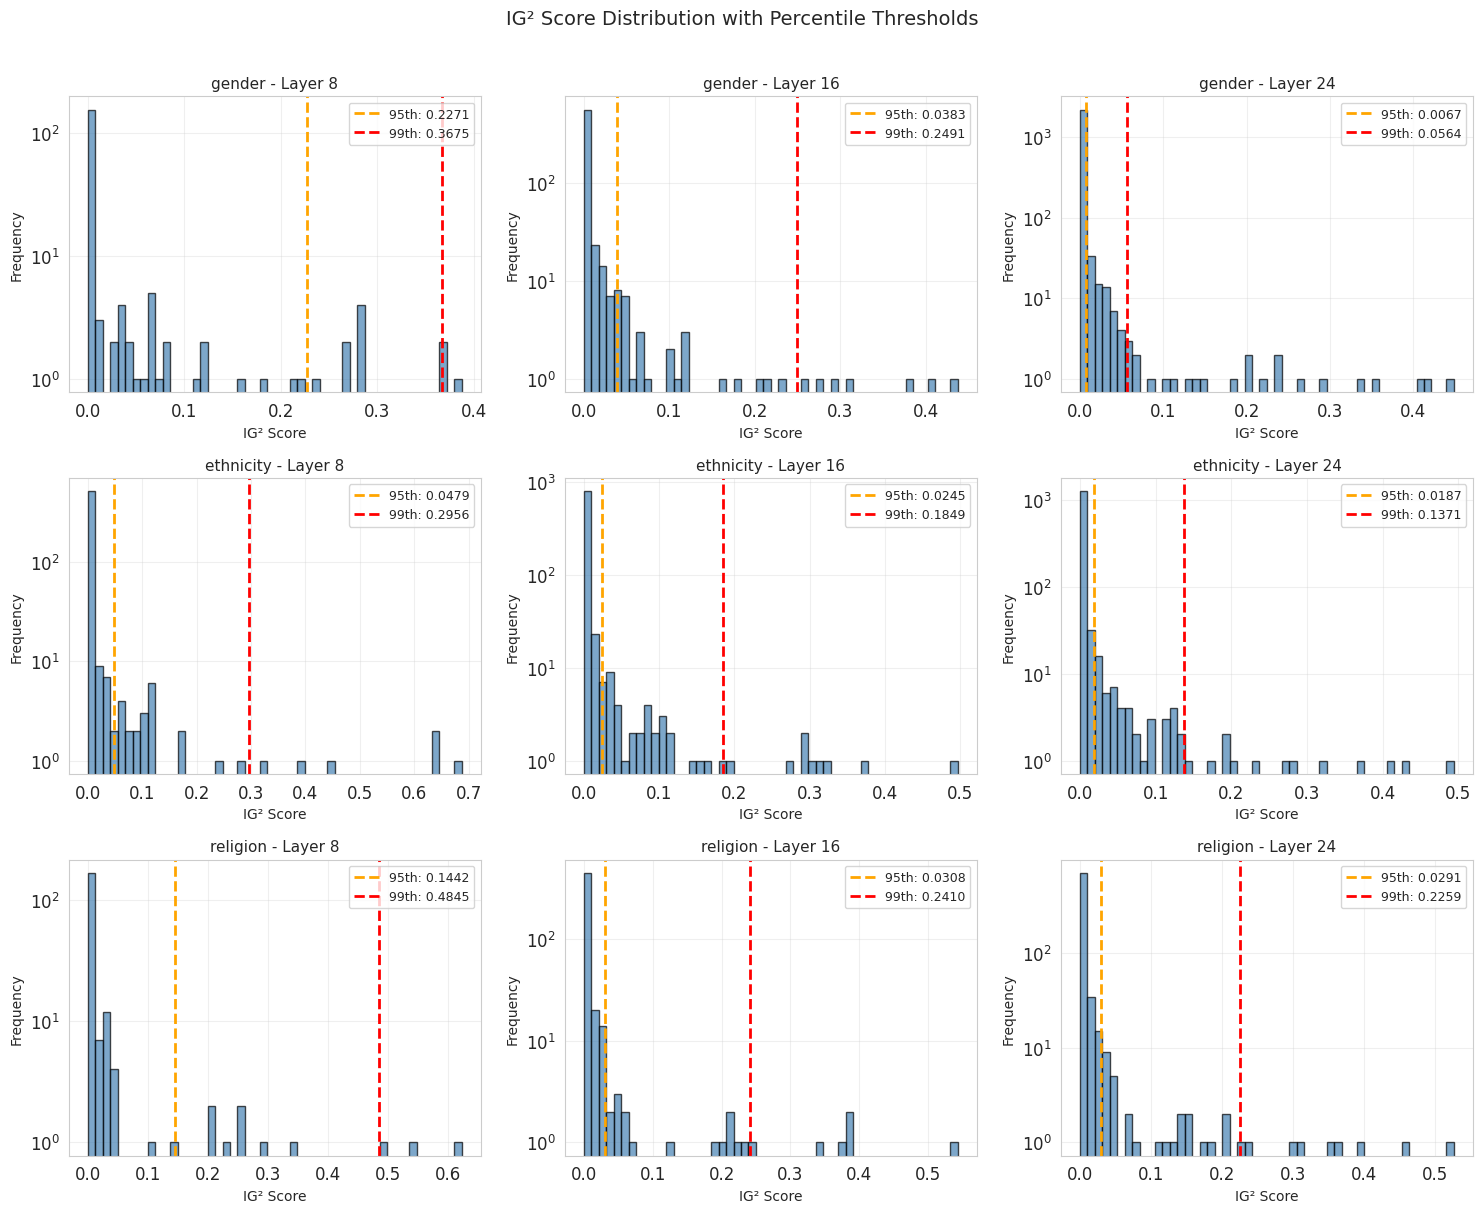

In [9]:
# Visualize: Score distribution with percentile lines for one example
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Select 3 representative demographics
demo_examples = DEMOGRAPHICS[:3]  # gender, ethnicity, religion

for i, demo in enumerate(demo_examples):
    demo_en = DEMOGRAPHIC_EN[demo]
    
    for j, lq in enumerate(LAYER_QUANTILES):
        ax = axes[i, j]
        
        if lq in ig2_data[demo]:
            scores = ig2_data[demo][lq]['scores']
            nonzero = scores[scores > 0]
            
            # Plot histogram
            ax.hist(nonzero, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
            
            # Add percentile lines
            colors = ['orange', 'red']
            for k, p in enumerate(PERCENTILES):
                threshold = np.percentile(nonzero, p)
                ax.axvline(threshold, color=colors[k], linestyle='--', linewidth=2, 
                          label=f'{p}th: {threshold:.4f}')
            
            ax.set_yscale('log')
            ax.legend(loc='upper right', fontsize=9)
        
        ax.set_title(f'{demo_en} - {LAYER_LABELS[lq]}', fontsize=11)
        ax.set_xlabel('IG² Score', fontsize=10)
        ax.set_ylabel('Frequency', fontsize=10)
        ax.grid(alpha=0.3)

plt.suptitle('IG² Score Distribution with Percentile Thresholds', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_score_distribution_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

## Section 2: Cross-Layer Trajectory Analysis

### How It's Computed:
We track four metrics across layers Layer 8→Layer 16→Layer 24: (1) Max IG² score - peak feature importance, (2) Important feature count at 99th percentile, (3) Concentration index - top-10 scores as fraction of total, (4) Layer change ratio between consecutive layers.

### Analysis:
Increasing max scores across layers suggests bias encoding strengthens in deeper layers. Increasing feature counts indicate bias information becomes more distributed. Decreasing concentration index means bias shifts from concentrated (few features) to diffuse (many features) encoding.

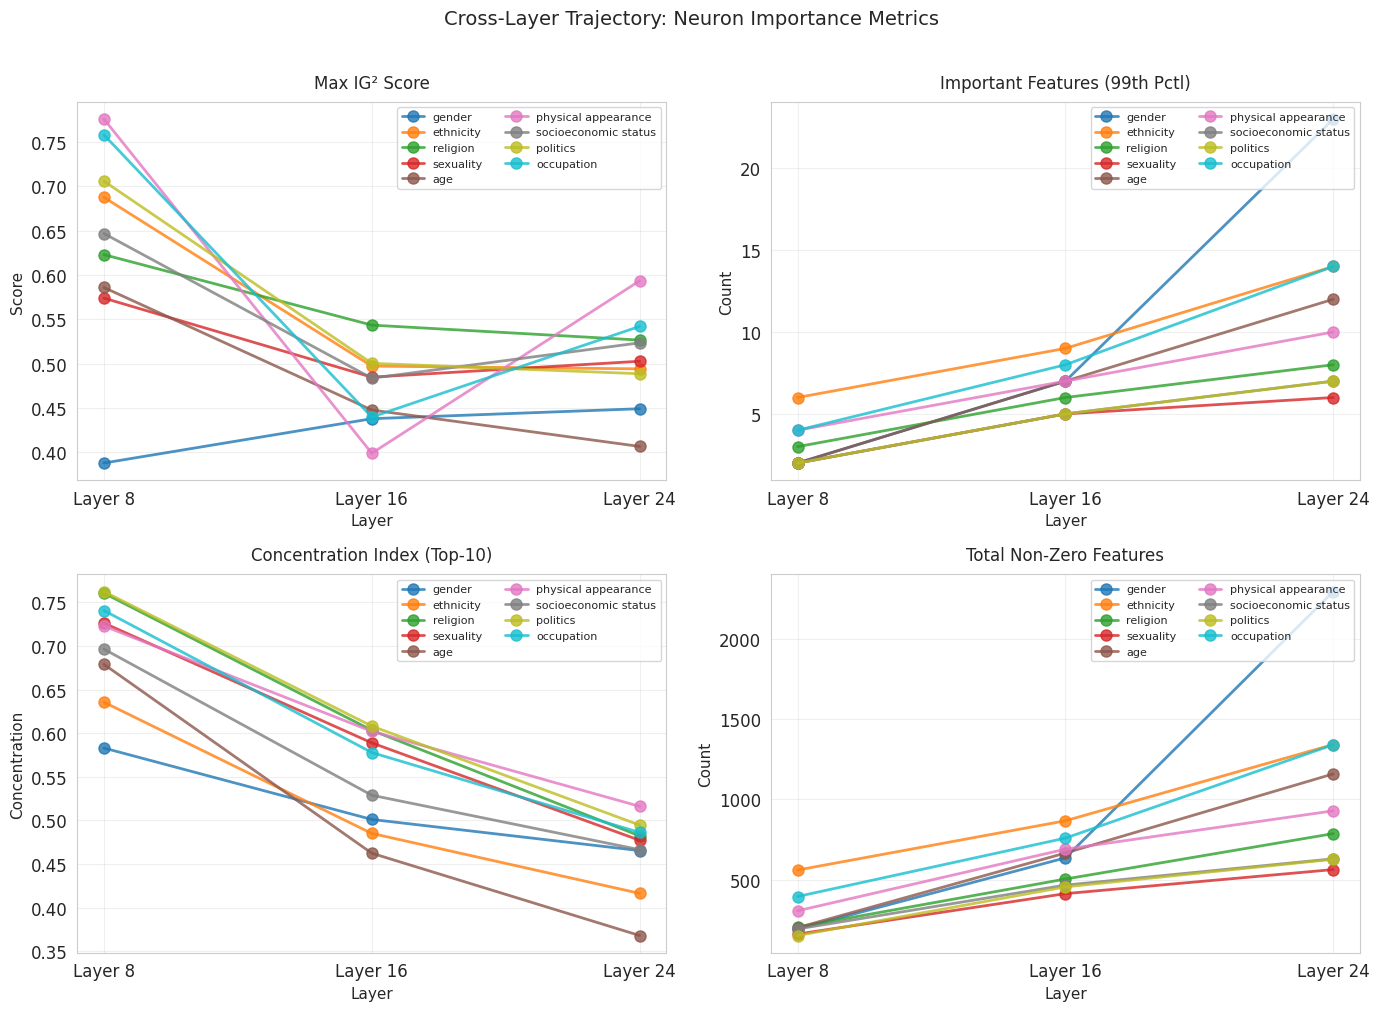

In [10]:
# Cross-layer trajectory: Line plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Max_Score', 'P99_Count', 'Concentration_Top10', 'Total_Nonzero']
titles = ['Max IG² Score', 'Important Features (99th Pctl)', 
          'Concentration Index (Top-10)', 'Total Non-Zero Features']
ylabels = ['Score', 'Count', 'Concentration', 'Count']

layer_x = [1, 2, 3]  # Layer 8, Layer 16, Layer 24

# Color palette for demographics
colors = plt.cm.tab10(np.linspace(0, 1, len(DEMOGRAPHICS)))

for idx, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
    ax = axes.flatten()[idx]
    
    for i, demo in enumerate(DEMOGRAPHICS):
        demo_en = DEMOGRAPHIC_EN[demo]
        
        values = []
        for lq in LAYER_QUANTILES:
            row = df_stats[(df_stats['Demographic'] == demo) & (df_stats['Layer'] == lq)]
            if len(row) > 0:
                values.append(row[metric].values[0])
            else:
                values.append(np.nan)
        
        ax.plot(layer_x, values, 'o-', label=demo_en, color=colors[i], 
               linewidth=2, markersize=8, alpha=0.8)
    
    ax.set_xticks(layer_x)
    ax.set_xticklabels(['Layer 8', 'Layer 16', 'Layer 24'])
    ax.set_xlabel('Layer', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=12, pad=10)
    ax.legend(loc='upper right', fontsize=8, ncol=2)
    ax.grid(alpha=0.3)

plt.suptitle('Cross-Layer Trajectory: Neuron Importance Metrics', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_layer_trajectory_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Compute layer change ratios
change_data = []

for demo in DEMOGRAPHICS:
    demo_en = DEMOGRAPHIC_EN[demo]
    
    # Get values for each layer
    values = {}
    for lq in LAYER_QUANTILES:
        row = df_stats[(df_stats['Demographic'] == demo) & (df_stats['Layer'] == lq)]
        if len(row) > 0:
            values[lq] = {
                'Max_Score': row['Max_Score'].values[0],
                'P99_Count': row['P99_Count'].values[0],
                'Concentration': row['Concentration_Top10'].values[0]
            }
    
    if len(values) == 3:  # All layers available
        for metric in ['Max_Score', 'P99_Count', 'Concentration']:
            # Q1->Q2 change
            if values['q1'][metric] > 0:
                change_q1_q2 = (values['q2'][metric] - values['q1'][metric]) / values['q1'][metric]
            else:
                change_q1_q2 = 0
            
            # Q2->Q3 change
            if values['q2'][metric] > 0:
                change_q2_q3 = (values['q3'][metric] - values['q2'][metric]) / values['q2'][metric]
            else:
                change_q2_q3 = 0
            
            # Q1->Q3 total change
            if values['q1'][metric] > 0:
                change_q1_q3 = (values['q3'][metric] - values['q1'][metric]) / values['q1'][metric]
            else:
                change_q1_q3 = 0
            
            change_data.append({
                'Demographic': demo,
                'Demographic_EN': demo_en,
                'Metric': metric,
                'Q1_Q2_Change': change_q1_q2 * 100,  # as percentage
                'Q2_Q3_Change': change_q2_q3 * 100,
                'Q1_Q3_Change': change_q1_q3 * 100
            })

df_changes = pd.DataFrame(change_data)
print("Layer change ratios computed (as %)")
print(df_changes.head(12).to_string(index=False))

Layer change ratios computed (as %)
Demographic Demographic_EN        Metric  Q1_Q2_Change  Q2_Q3_Change  Q1_Q3_Change
         성별         gender     Max_Score     12.910624      2.573422     15.816291
         성별         gender     P99_Count    250.000000    228.571429   1050.000000
         성별         gender Concentration    -14.054118     -7.135972    -20.187191
         인종      ethnicity     Max_Score    -27.716801     -0.621065    -28.165726
         인종      ethnicity     P99_Count     50.000000     55.555556    133.333333
         인종      ethnicity Concentration    -23.688625    -14.181701    -34.510876
         종교       religion     Max_Score    -12.773681     -3.112336    -15.488456
         종교       religion     P99_Count    100.000000     33.333333    166.666667
         종교       religion Concentration    -20.686487    -20.077816    -36.610909
       성적지향      sexuality     Max_Score    -15.547758      3.701939    -12.421389
       성적지향      sexuality     P99_Count    150.000

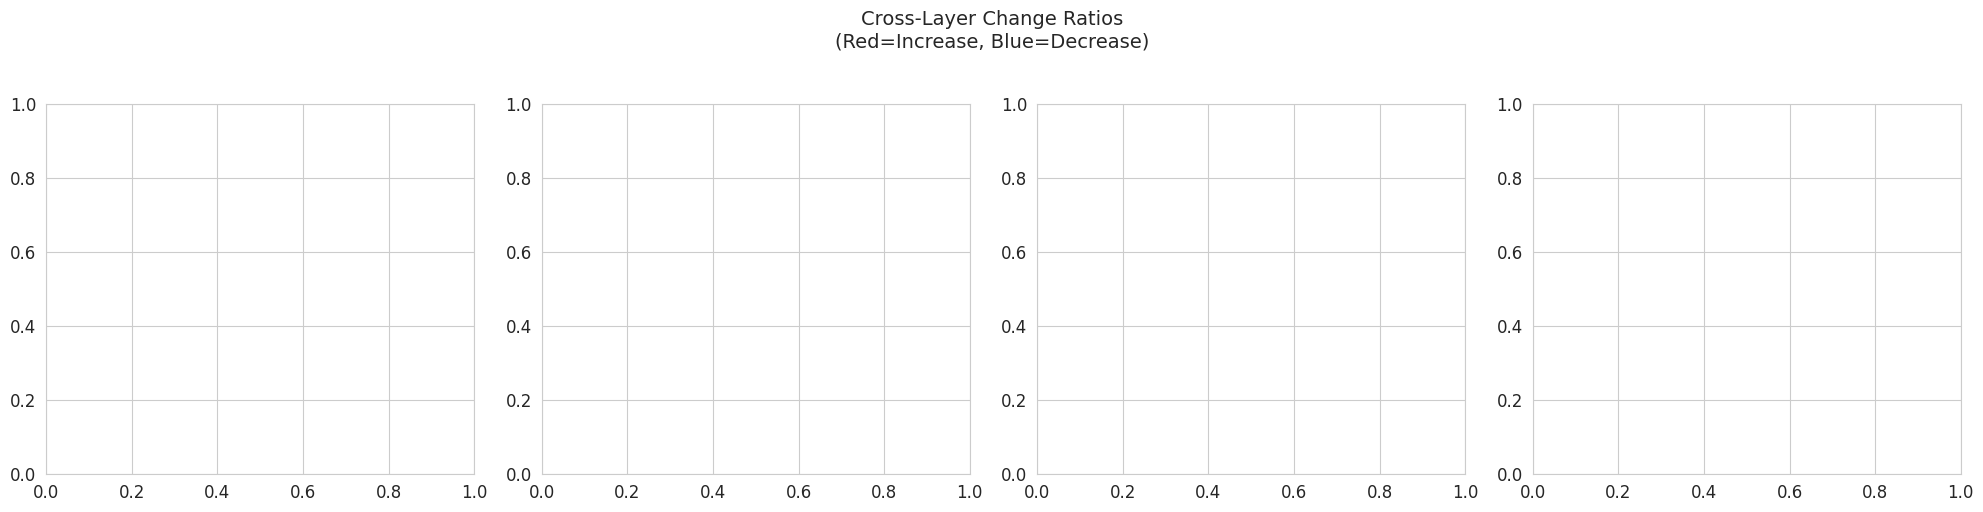

In [12]:
# Heatmap of layer changes for Max_Score
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

demo_en_ordered = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
metrics_to_plot = ['Max_Score', 'P99_Count', 'Concentration_Top10', 'Total_Nonzero']
metric_titles = ['Max IG² Score', 'P99 Count', 'Concentration', 'Total Non-Zero']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, metric_titles)):
    ax = axes[idx]
    
    col_q1_q2 = f'{metric}_Q1_to_Q2'
    col_q2_q3 = f'{metric}_Q2_to_Q3'
    
    if col_q1_q2 not in df_changes.columns:
        continue
    
    # Create pivot table
    data = df_changes[['Demographic_EN', col_q1_q2, col_q2_q3]].set_index('Demographic_EN')
    data = data.reindex(demo_en_ordered)
    data.columns = ['Layer 8→16', 'Layer 16→24']
    
    # Clip extreme values for visualization
    data_clipped = data.clip(lower=-200, upper=200)
    
    sns.heatmap(
        data_clipped,
        annot=True,
        fmt='.0f',
        cmap='RdBu_r',
        center=0,
        ax=ax,
        cbar_kws={'label': 'Change (%)'},
        linewidths=0.5,
        annot_kws={'fontsize': 9}
    )
    
    ax.set_title(f'{title}', fontsize=12, pad=10)
    ax.set_xlabel('Layer Transition', fontsize=11)
    ax.set_ylabel('Demographic' if idx == 0 else '', fontsize=11)

plt.suptitle('Cross-Layer Change Ratios\n(Red=Increase, Blue=Decrease)', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_layer_changes_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Cross-Demographic Comparison (Within-Layer)

### How It's Computed:
For each layer, we compute Jaccard similarity between all pairs of demographics: J(A,B) = |A∩B| / |A∪B|, where A and B are sets of important feature indices (99th percentile). Higher similarity means demographics share more bias-encoding features.

### Analysis:
High similarity across demographics within a layer suggests common bias-encoding mechanisms. Low similarity means demographic-specific encoding. We analyze shared features: those important for multiple demographics may encode general "group identity" concepts rather than specific biases.

In [13]:
def compute_jaccard_similarity(set_a, set_b):
    """Compute Jaccard similarity between two sets."""
    set_a = set(set_a)
    set_b = set(set_b)
    
    intersection = len(set_a & set_b)
    union = len(set_a | set_b)
    
    if union == 0:
        return 0.0
    return intersection / union


# Compute Jaccard similarity matrices for each layer
jaccard_matrices = {}

for lq in LAYER_QUANTILES:
    n_demo = len(DEMOGRAPHICS)
    matrix = np.zeros((n_demo, n_demo))
    
    for i, demo_i in enumerate(DEMOGRAPHICS):
        for j, demo_j in enumerate(DEMOGRAPHICS):
            if i == j:
                matrix[i, j] = 1.0
            else:
                # Get important features for both demographics
                row_i = df_stats[(df_stats['Demographic'] == demo_i) & (df_stats['Layer'] == lq)]
                row_j = df_stats[(df_stats['Demographic'] == demo_j) & (df_stats['Layer'] == lq)]
                
                if len(row_i) > 0 and len(row_j) > 0:
                    indices_i = row_i['P99_Indices'].values[0]
                    indices_j = row_j['P99_Indices'].values[0]
                    matrix[i, j] = compute_jaccard_similarity(indices_i, indices_j)
    
    jaccard_matrices[lq] = matrix

print("Jaccard similarity matrices computed for each layer.")

Jaccard similarity matrices computed for each layer.


Layer 8: [[1.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         1.         0.5        0.33333333 0.33333333 0.66666667
  0.33333333 0.33333333 0.66666667]
 [0.         0.5        1.         0.66666667 0.66666667 0.75
  0.66666667 0.66666667 0.75      ]
 [0.         0.33333333 0.66666667 1.         1.         0.5
  1.         1.         0.5       ]
 [0.         0.33333333 0.66666667 1.         1.         0.5
  1.         1.         0.5       ]
 [0.         0.66666667 0.75       0.5        0.5        1.
  0.5        0.5        1.        ]
 [0.         0.33333333 0.66666667 1.         1.         0.5
  1.         1.         0.5       ]
 [0.         0.33333333 0.66666667 1.         1.         0.5
  1.         1.         0.5       ]
 [0.         0.66666667 0.75       0.5        0.5        1.
  0.5        0.5        1.        ]]
Layer 16: [[1.         0.         0.3        0.33333333 0.16666667 0.27272727
  0.2        0.33333333 0.25      

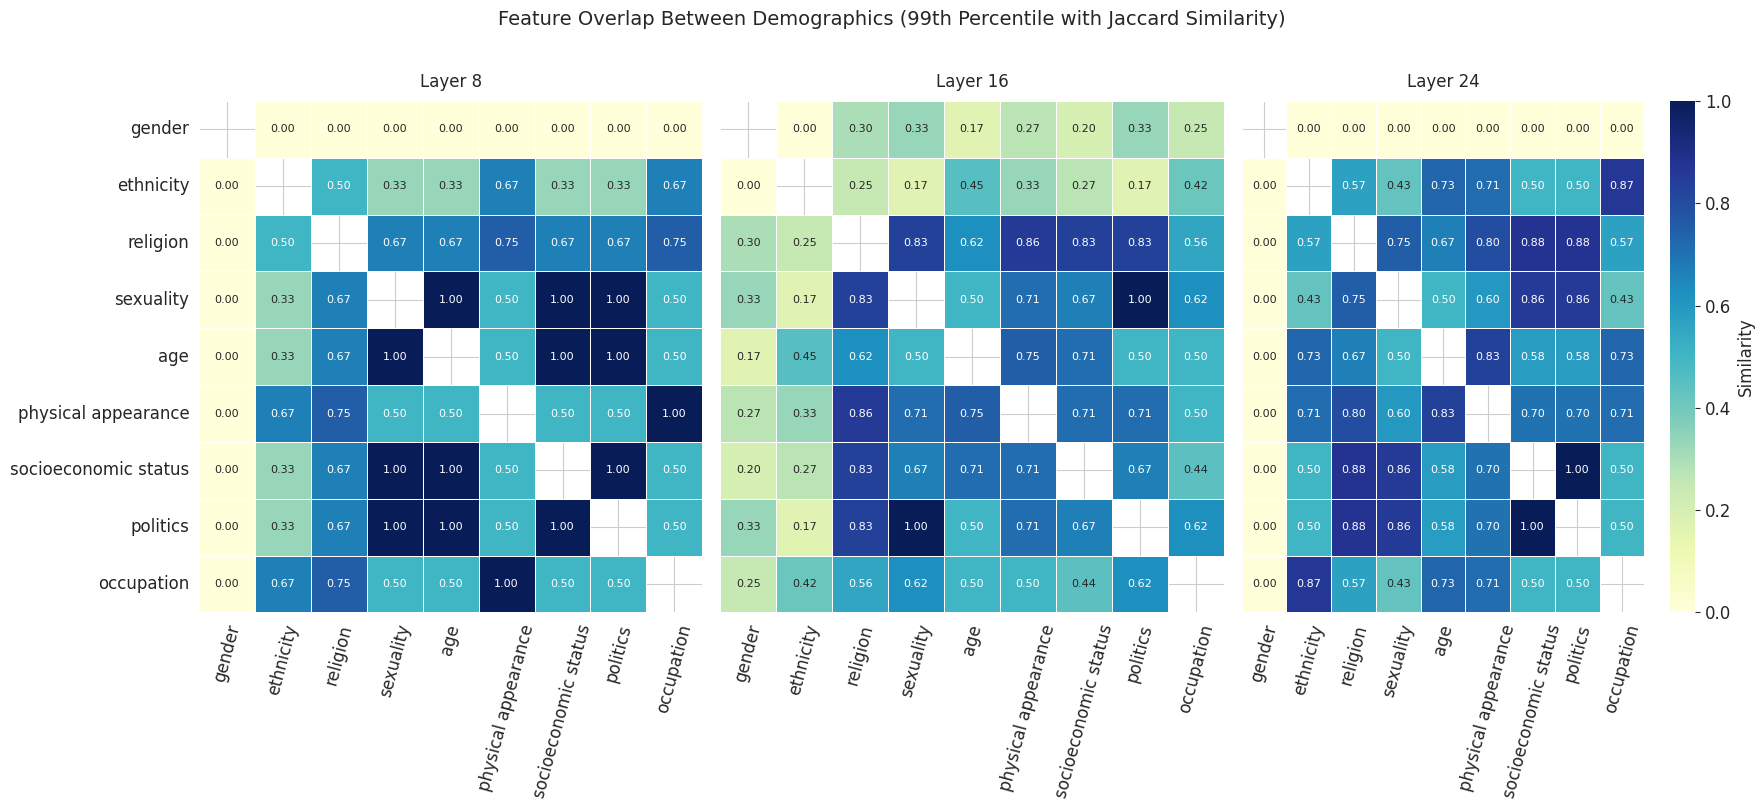


Average Jaccard Similarity (excluding diagonal):
  Layer 8: 0.509 (std=0.340)
  Layer 16: 0.502 (std=0.241)
  Layer 24: 0.526 (std=0.312)


In [26]:
# Visualize Jaccard similarity heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

demo_en_labels = [DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]

for idx, lq in enumerate(LAYER_QUANTILES):
    ax = axes[idx]
    
    matrix = jaccard_matrices[lq]
    
    # Create DataFrame for better labeling
    df_matrix = pd.DataFrame(matrix, index=demo_en_labels, columns=demo_en_labels)
    
    # Mask diagonal for cleaner visualization
    mask = np.eye(len(DEMOGRAPHICS), dtype=bool)
    
    sns.heatmap(
        df_matrix,
        annot=True,
        fmt='.2f',
        cmap='YlGnBu',
        vmin=0,
        vmax=1,
        ax=ax,
        mask=mask,
        cbar=True if idx > 1 else False,
        cbar_kws={'label': 'Similarity'} if idx > 1 else None,
        linewidths=0.5,
        annot_kws={'fontsize': 8}
    )
    
    ax.set_title(f'{LAYER_LABELS[lq]}', fontsize=12, pad=10)
    ax.tick_params(axis='x', rotation=75)  # Set x-axis rotation to 75 degrees
    ax.tick_params(axis='y', rotation=0)
    
    # Remove y-axis for Layer 16 and Layer 24 (idx > 0)
    if idx > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    print(f'{LAYER_LABELS[lq]}: {df_matrix.values}')

plt.suptitle('Feature Overlap Between Demographics (99th Percentile with Jaccard Similarity)', 
             fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_jaccard_similarity_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

# Print average similarity per layer
print("\nAverage Jaccard Similarity (excluding diagonal):")
for lq in LAYER_QUANTILES:
    matrix = jaccard_matrices[lq]
    # Get off-diagonal elements
    off_diag = matrix[~np.eye(matrix.shape[0], dtype=bool)]
    print(f"  {LAYER_LABELS[lq]}: {off_diag.mean():.3f} (std={off_diag.std():.3f})")

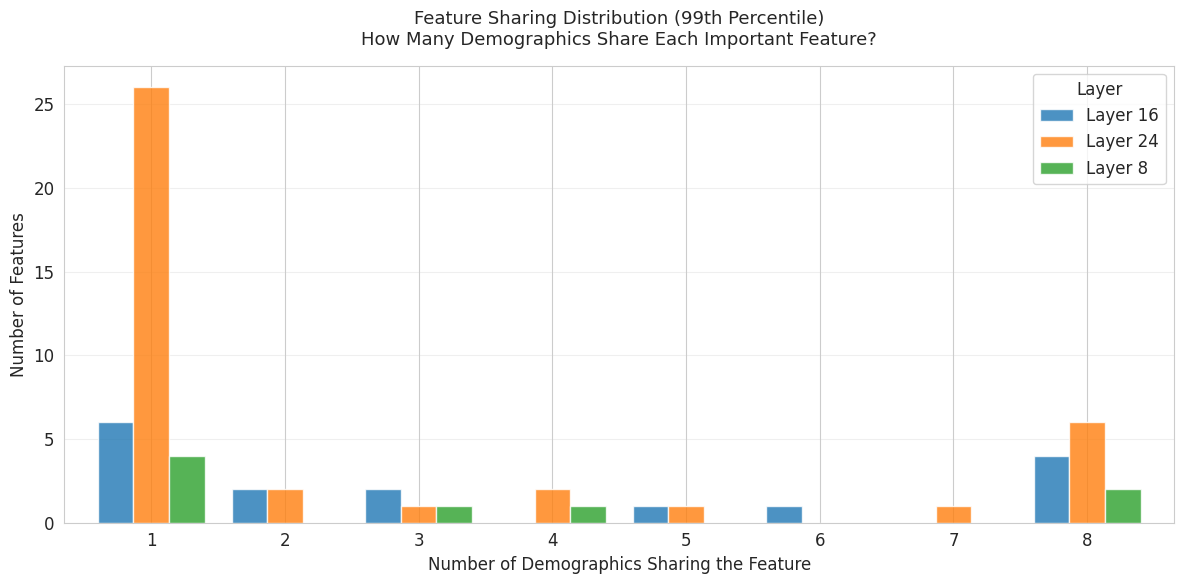


Feature Sharing Summary:
  Layer 8: 8 total features, 4 unique (1 demo), 4 shared (3+ demos)
  Layer 16: 16 total features, 6 unique (1 demo), 8 shared (3+ demos)
  Layer 24: 39 total features, 26 unique (1 demo), 11 shared (3+ demos)


In [15]:
# Analyze shared vs unique features
shared_features_data = []

for lq in LAYER_QUANTILES:
    # Collect all important features for this layer
    all_features = {}
    for demo in DEMOGRAPHICS:
        row = df_stats[(df_stats['Demographic'] == demo) & (df_stats['Layer'] == lq)]
        if len(row) > 0:
            all_features[demo] = set(row['P99_Indices'].values[0])
    
    # Count how many demographics each feature appears in
    feature_counts = defaultdict(int)
    for demo, features in all_features.items():
        for f in features:
            feature_counts[f] += 1
    
    # Group by count
    count_distribution = defaultdict(int)
    for f, count in feature_counts.items():
        count_distribution[count] += 1
    
    for count, n_features in count_distribution.items():
        shared_features_data.append({
            'Layer': lq,
            'Layer_Label': LAYER_LABELS[lq],
            'Shared_By_N_Demographics': count,
            'Feature_Count': n_features
        })

df_shared = pd.DataFrame(shared_features_data)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))

# Pivot for grouped bar chart
pivot = df_shared.pivot(index='Shared_By_N_Demographics', columns='Layer_Label', values='Feature_Count')
pivot = pivot.fillna(0).astype(int)

pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)

ax.set_xlabel('Number of Demographics Sharing the Feature', fontsize=12)
ax.set_ylabel('Number of Features', fontsize=12)
ax.set_title('Feature Sharing Distribution (99th Percentile)\nHow Many Demographics Share Each Important Feature?', 
             fontsize=13, pad=15)
ax.legend(title='Layer')
ax.tick_params(axis='x', rotation=0)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_sharing_distribution_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

# Summary
print("\nFeature Sharing Summary:")
for lq in LAYER_QUANTILES:
    lq_data = df_shared[df_shared['Layer'] == lq]
    total = lq_data['Feature_Count'].sum()
    unique = lq_data[lq_data['Shared_By_N_Demographics'] == 1]['Feature_Count'].sum()
    shared_3plus = lq_data[lq_data['Shared_By_N_Demographics'] >= 3]['Feature_Count'].sum()
    print(f"  {LAYER_LABELS[lq]}: {total} total features, {unique} unique (1 demo), {shared_3plus} shared (3+ demos)")

In [16]:
# Analyze shared features
shared_feature_data = []

for lq in LAYER_QUANTILES:
    # Collect all important features for this layer
    all_features = defaultdict(int)
    
    for demo in DEMOGRAPHICS:
        row = df_stats[(df_stats['Demographic'] == demo) & (df_stats['Layer'] == lq)]
        if len(row) > 0:
            indices = row['P99_Feature_Indices'].values[0]
            if indices is not None and len(indices) > 0:
                for idx in indices:
                    all_features[idx] += 1
    
    # Count by number of demographics sharing
    for feature_idx, count in all_features.items():
        shared_feature_data.append({
            'Layer': lq,
            'Layer_Label': LAYER_LABELS[lq],
            'Feature_Index': feature_idx,
            'Shared_By_N_Demographics': count
        })

df_shared = pd.DataFrame(shared_feature_data)

if len(df_shared) > 0:
    # Grouped bar: count features by how many demographics share them
    fig, ax = plt.subplots(figsize=(12, 5))
    
    pivot = df_shared.pivot(index='Shared_By_N_Demographics', columns='Layer_Label', values='Feature_Index')
    # Count occurrences instead of values
    pivot = df_shared.groupby(['Shared_By_N_Demographics', 'Layer_Label']).size().unstack(fill_value=0)
    pivot = pivot[['Layer 8', 'Layer 16', 'Layer 24']]  # Reorder columns
    
    pivot.plot(kind='bar', ax=ax, width=0.8, alpha=0.8)
    ax.set_xlabel('Shared By N Demographics', fontsize=12)
    ax.set_ylabel('Number of Features', fontsize=12)
    ax.set_title('Feature Sharing Distribution\n(How many demographics share each feature?)', fontsize=13, pad=15)
    ax.legend(title='Layer')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(ASSETS_DIR / f"important_neurons_shared_features_{STAGE}.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print("\nShared Feature Statistics:")
    for lq in LAYER_QUANTILES:
        lq_data = df_shared[df_shared['Layer'] == lq]
        total = len(lq_data)
        unique = len(lq_data[lq_data['Shared_By_N_Demographics'] == 1])
        shared_3plus = len(lq_data[lq_data['Shared_By_N_Demographics'] >= 3])
        print(f"  {LAYER_LABELS[lq]}: {total} total features, {unique} unique (1 demo), {shared_3plus} shared (3+ demos)")

KeyError: 'P99_Feature_Indices'

# Distribution of features by sharing count - per-layer heatmaps (similar style to Jaccard)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, lq in enumerate(LAYER_QUANTILES):
    ax = axes[idx]
    
    lq_data = df_shared[df_shared['Layer'] == lq]
    
    if len(lq_data) > 0:
        # Create matrix: demographics x sharing count
        # For each demographic, count how many of its features are shared by N demographics
        matrix_data = []
        
        for demo in DEMOGRAPHICS:
            demo_en = DEMOGRAPHIC_EN[demo]
            row = df_stats[(df_stats['Demographic'] == demo) & (df_stats['Layer'] == lq)]
            if len(row) > 0:
                indices = row['P99_Feature_Indices'].values[0]
                if indices is not None and len(indices) > 0:
                    # For each feature, find how many demos share it
                    sharing_counts = []
                    for feat_idx in indices:
                        count = df_shared[(df_shared['Layer'] == lq) & 
                                         (df_shared['Feature_Index'] == feat_idx)]['Shared_By_N_Demographics'].values
                        if len(count) > 0:
                            sharing_counts.append(count[0])
                    
                    # Count distribution
                    unique_only = sum(1 for c in sharing_counts if c == 1)
                    shared_2 = sum(1 for c in sharing_counts if c == 2)
                    shared_3plus = sum(1 for c in sharing_counts if c >= 3)
                    matrix_data.append({
                        'Demographic': demo_en,
                        'Unique (1)': unique_only,
                        'Shared (2)': shared_2,
                        'Shared (3+)': shared_3plus
                    })
        
        if matrix_data:
            df_matrix = pd.DataFrame(matrix_data).set_index('Demographic')
            
            sns.heatmap(
                df_matrix,
                annot=True,
                fmt='d',
                cmap='YlOrRd',
                ax=ax,
                cbar_kws={'label': 'Feature Count'},
                linewidths=0.5
            )
    
    ax.set_title(f'{LAYER_LABELS[lq]}', fontsize=12, pad=10)
    ax.tick_params(axis='x', rotation=75)  # Set x-axis rotation to 75 degrees
    ax.tick_params(axis='y', rotation=0)
    
    # Remove y-axis for Layer 16 and Layer 24 (idx > 0)
    if idx > 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])

plt.suptitle('Feature Sharing Pattern per Demographic (99th Percentile)\n(Unique=1 demo, Shared=multiple demos)', 
             fontsize=14, y=1.05)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_sharing_pattern_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Extract top-10 features for each demographic-layer
top_features_data = []

for demo in DEMOGRAPHICS:
    demo_en = DEMOGRAPHIC_EN[demo]
    for lq in LAYER_QUANTILES:
        if lq in ig2_data[demo]:
            scores = ig2_data[demo][lq]['scores']
            
            # Get top-10 indices
            top_indices = np.argsort(scores)[-10:][::-1]
            
            for rank, idx in enumerate(top_indices, 1):
                top_features_data.append({
                    'Demographic': demo,
                    'Demographic_EN': demo_en,
                    'Layer': lq,
                    'Rank': rank,
                    'Feature_Index': int(idx),
                    'IG2_Score': scores[idx]
                })

df_top_features = pd.DataFrame(top_features_data)
print(f"Extracted {len(df_top_features)} top-10 feature entries")
print("\nSample:")
print(df_top_features.head(15).to_string(index=False))

Extracted 270 top-10 feature entries

Sample:
Demographic Demographic_EN Layer  Rank  Feature_Index  IG2_Score
         성별         gender    q1     1          53911   0.387639
         성별         gender    q1     2          37172   0.371373
         성별         gender    q1     3          26240   0.367063
         성별         gender    q1     4          75157   0.285358
         성별         gender    q1     5          68397   0.283881
         성별         gender    q1     6          73781   0.279359
         성별         gender    q1     7          23063   0.279337
         성별         gender    q1     8          72363   0.265422
         성별         gender    q1     9           4497   0.264446
         성별         gender    q1    10          24552   0.233029
         성별         gender    q2     1          67974   0.437685
         성별         gender    q2     2          50376   0.406557
         성별         gender    q2     3          57652   0.381049
         성별         gender    q2     4      

In [ ]:
# Identify features that appear in top-10 across multiple demographics (per layer)
universal_features = []

for lq in LAYER_QUANTILES:
    layer_data = df_top_features[df_top_features['Layer'] == lq]
    
    # Count appearances of each feature
    feature_counts = layer_data.groupby('Feature_Index').agg({
        'Demographic_EN': lambda x: list(x),
        'IG2_Score': 'mean',
        'Rank': 'mean'
    }).reset_index()
    
    feature_counts['N_Demographics'] = feature_counts['Demographic_EN'].apply(len)
    feature_counts['Layer'] = lq
    
    # Filter to features appearing in 2+ demographics
    multi_demo = feature_counts[feature_counts['N_Demographics'] >= 2].copy()
    multi_demo = multi_demo.sort_values('N_Demographics', ascending=False)
    
    universal_features.append(multi_demo)

df_universal = pd.concat(universal_features, ignore_index=True)

print("Features appearing in top-10 across multiple demographics:")
print("=" * 80)

for lq in LAYER_QUANTILES:
    lq_data = df_universal[df_universal['Layer'] == lq]
    print(f"\n{LAYER_LABELS[lq]}:")
    if len(lq_data) > 0:
        for _, row in lq_data.head(5).iterrows():
            demos = ', '.join(row['Demographic_EN'][:3])
            if len(row['Demographic_EN']) > 3:
                demos += f' +{len(row["Demographic_EN"])-3} more'
            print(f"  Feature #{row['Feature_Index']:5d}: {row['N_Demographics']} demographics, "
                  f"avg score={row['IG2_Score']:.4f} [{demos}]")
    else:
        print("  No features shared across multiple demographics")

Features appearing in top-10 across multiple demographics:

Layer Q1 (25%):
  Feature #  537: 8 demographics, avg score=0.2602 [ethnicity, religion, sexuality +5 more]
  Feature #12574: 8 demographics, avg score=0.5774 [ethnicity, religion, sexuality +5 more]
  Feature #38258: 8 demographics, avg score=0.6628 [ethnicity, religion, sexuality +5 more]
  Feature #92513: 8 demographics, avg score=0.5207 [ethnicity, religion, sexuality +5 more]
  Feature #53911: 8 demographics, avg score=0.3098 [gender, religion, sexuality +5 more]

Layer Q2 (50%):
  Feature #24038: 8 demographics, avg score=0.3558 [ethnicity, religion, sexuality +5 more]
  Feature #31076: 8 demographics, avg score=0.3163 [gender, religion, sexuality +5 more]
  Feature #63312: 8 demographics, avg score=0.2140 [ethnicity, religion, sexuality +5 more]
  Feature #57652: 8 demographics, avg score=0.2644 [gender, religion, sexuality +5 more]
  Feature #83760: 8 demographics, avg score=0.3302 [ethnicity, religion, sexuality +5 mo

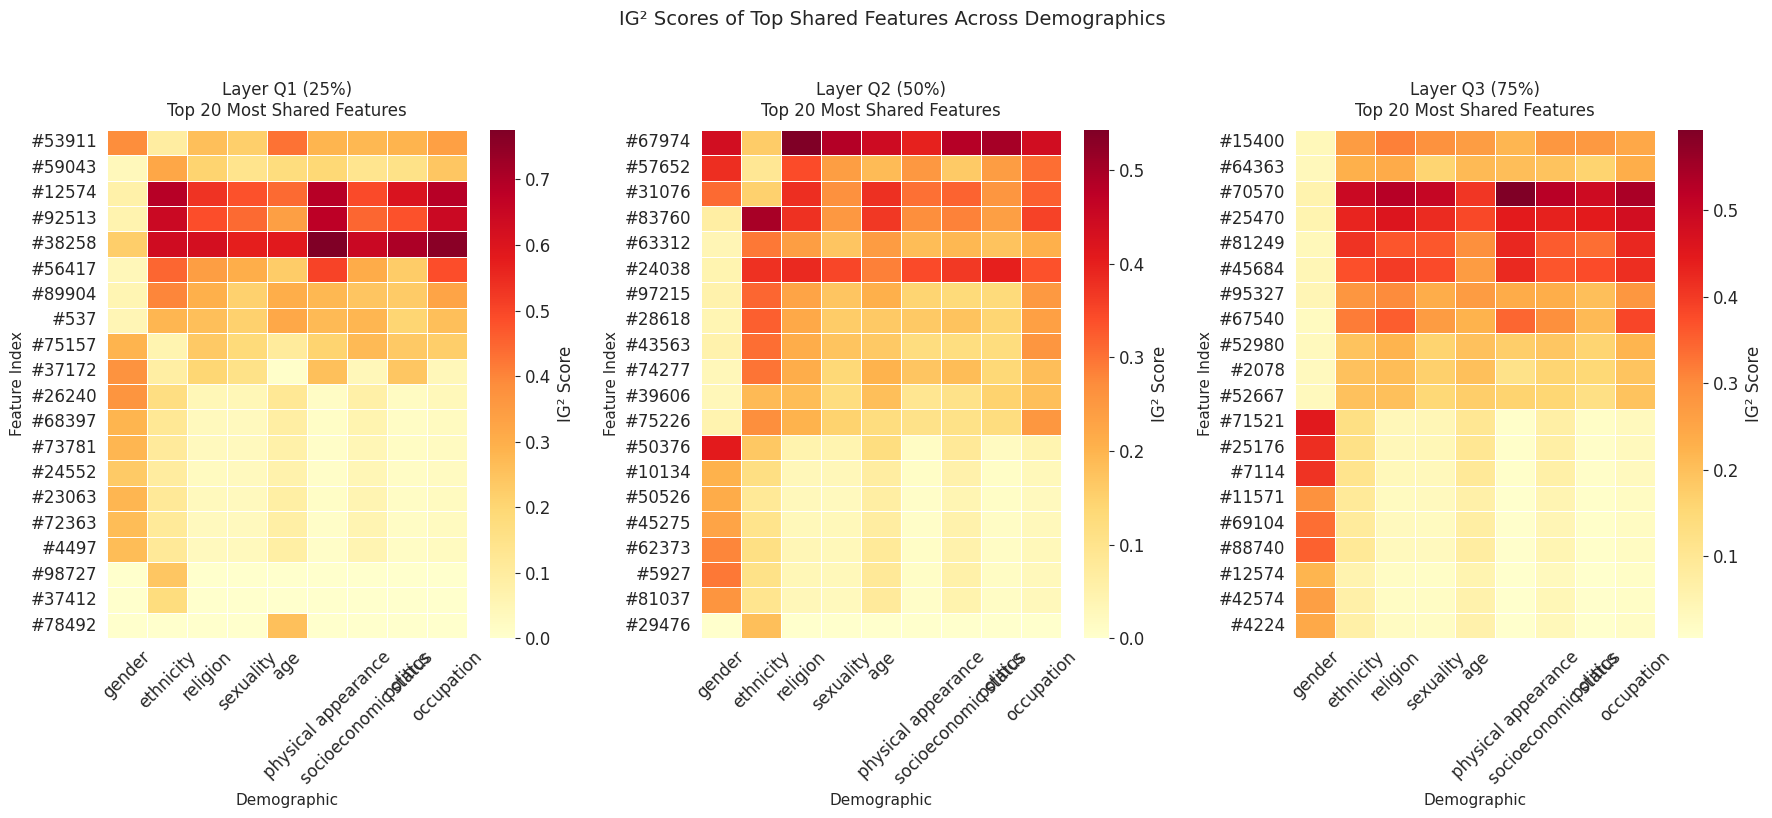

In [ ]:
# Visualize: Feature-Demographic heatmap for top shared features
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

for idx, lq in enumerate(LAYER_QUANTILES):
    ax = axes[idx]
    
    # Get top 20 most frequently appearing features for this layer
    layer_data = df_top_features[df_top_features['Layer'] == lq]
    feature_counts = layer_data['Feature_Index'].value_counts().head(20)
    top_feature_indices = feature_counts.index.tolist()
    
    # Create matrix: features x demographics
    matrix = np.zeros((len(top_feature_indices), len(DEMOGRAPHICS)))
    
    for i, feat_idx in enumerate(top_feature_indices):
        for j, demo in enumerate(DEMOGRAPHICS):
            if lq in ig2_data[demo]:
                scores = ig2_data[demo][lq]['scores']
                matrix[i, j] = scores[feat_idx]
    
    # Create DataFrame
    df_matrix = pd.DataFrame(
        matrix,
        index=[f'#{idx}' for idx in top_feature_indices],
        columns=[DEMOGRAPHIC_EN[d] for d in DEMOGRAPHICS]
    )
    
    sns.heatmap(
        df_matrix,
        cmap='YlOrRd',
        ax=ax,
        cbar_kws={'label': 'IG² Score'},
        linewidths=0.5,
    )
    
    ax.set_title(f'{LAYER_LABELS[lq]}\nTop 20 Most Shared Features', fontsize=12, pad=10)
    ax.set_xlabel('Demographic', fontsize=11)
    ax.set_ylabel('Feature Index', fontsize=11)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('IG² Scores of Top Shared Features Across Demographics', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(ASSETS_DIR / f"important_neurons_feature_demographic_heatmap_{STAGE}.png", dpi=300, bbox_inches='tight')
plt.show()

---
## Section 5: Summary Statistics & Export

### Purpose:
Aggregate all findings into exportable summary tables for further analysis or reporting.

In [ ]:
# Create comprehensive summary DataFrame
summary_cols = ['Demographic_EN', 'Layer', 'Max_Score', 'Max_Neuron_Idx', 
                'Total_Nonzero', 'P95_Count', 'P99_Count', 
                'Concentration_Top10', 'Concentration_Top50']

df_export = df_stats[summary_cols].copy()
df_export.columns = ['Demographic', 'Layer', 'Max_IG2_Score', 'Top_Neuron_Index',
                     'Nonzero_Features', 'P95_Count', 'P99_Count',
                     'Concentration_Top10', 'Concentration_Top50']

# Save to CSV
export_path = ASSETS_DIR / f"important_neurons_summary_{STAGE}.csv"
df_export.to_csv(export_path, index=False)
print(f"Summary exported to: {export_path}")

# Display
print("\n" + "=" * 100)
print("IMPORTANT NEURONS SUMMARY")
print("=" * 100)
print(df_export.to_string(index=False))

Summary exported to: /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/important_neurons_summary_full.csv

IMPORTANT NEURONS SUMMARY
         Demographic Layer  Max_IG2_Score  Top_Neuron_Index  Nonzero_Features  P95_Count  P99_Count  Concentration_Top10  Concentration_Top50
              gender    q1       0.387639             53911               192         10          2             0.582999             0.999998
              gender    q2       0.437685             67974               635         32          7             0.501064             0.881915
              gender    q3       0.448949             71521              2294        115         23             0.465308             0.834471
           ethnicity    q1       0.687645             12574               559         28          6             0.635601             0.978448
           ethnicity    q2       0.497052             83760               866         44          9             0.485036            

In [ ]:
# Export top features list
top_features_export = df_top_features[['Demographic_EN', 'Layer', 'Rank', 'Feature_Index', 'IG2_Score']].copy()
top_features_export.columns = ['Demographic', 'Layer', 'Rank', 'Feature_Index', 'IG2_Score']

export_path_features = ASSETS_DIR / f"important_neurons_top_features_{STAGE}.csv"
top_features_export.to_csv(export_path_features, index=False)
print(f"Top features exported to: {export_path_features}")

# Summary statistics
print("\n" + "=" * 80)
print("KEY FINDINGS SUMMARY")
print("=" * 80)

print("\n1. Feature Concentration:")
for lq in LAYER_QUANTILES:
    lq_data = df_stats[df_stats['Layer'] == lq]
    avg_conc = lq_data['Concentration_Top10'].mean()
    print(f"   {LAYER_LABELS[lq]}: Top-10 features capture {avg_conc*100:.1f}% of total IG² score (avg)")

print("\n2. Cross-Demographic Similarity:")
for lq in LAYER_QUANTILES:
    matrix = jaccard_matrices[lq]
    off_diag = matrix[~np.eye(matrix.shape[0], dtype=bool)]
    print(f"   {LAYER_LABELS[lq]}: Average Jaccard similarity = {off_diag.mean():.3f}")

print("\n3. Universal Features (appearing in 3+ demographics' top-10):")
for lq in LAYER_QUANTILES:
    lq_data = df_universal[(df_universal['Layer'] == lq) & (df_universal['N_Demographics'] >= 3)]
    print(f"   {LAYER_LABELS[lq]}: {len(lq_data)} universal features")

Top features exported to: /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets/important_neurons_top_features_full.csv

KEY FINDINGS SUMMARY

1. Feature Concentration:
   Layer Q1 (25%): Top-10 features capture 70.1% of total IG² score (avg)
   Layer Q2 (50%): Top-10 features capture 55.1% of total IG² score (avg)
   Layer Q3 (75%): Top-10 features capture 46.4% of total IG² score (avg)

2. Cross-Demographic Similarity:
   Layer Q1 (25%): Average Jaccard similarity = 0.509
   Layer Q2 (50%): Average Jaccard similarity = 0.502
   Layer Q3 (75%): Average Jaccard similarity = 0.526

3. Universal Features (appearing in 3+ demographics' top-10):
   Layer Q1 (25%): 11 universal features
   Layer Q2 (50%): 12 universal features
   Layer Q3 (75%): 11 universal features


In [ ]:
print("\n" + "=" * 70)
print("Important Neuron Analysis Complete!")
print("=" * 70)
print(f"\nAssets saved to: {ASSETS_DIR}")
print("\nGenerated files:")
for f in sorted(ASSETS_DIR.glob(f"important_neurons*_{STAGE}*")):
    print(f"  - {f.name}")


Important Neuron Analysis Complete!

Assets saved to: /home/youngjins/project/global_ai_frontier/notebooks/visualizations/assets

Generated files:
  - important_neurons_demographic_clustering_full.png
  - important_neurons_feature_demographic_heatmap_full.png
  - important_neurons_jaccard_similarity_full.png
  - important_neurons_layer_changes_full.png
  - important_neurons_layer_trajectory_full.png
  - important_neurons_percentile_counts_full.png
  - important_neurons_score_distribution_full.png
  - important_neurons_sharing_distribution_full.png
  - important_neurons_summary_full.csv
  - important_neurons_top_features_full.csv
